In [72]:
import numpy as np
import pandas as pd
import re
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
import json
import datetime as dt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dot, Embedding, Flatten, Dense

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [73]:
path = "/home/koki/Desktop/Data/OutOfStock/preprocessed.csv"
# "/home/koki/Desktop/Data/OutOfStock/LEMeldungen_2021-11-01-16-50-35.csv"
df = pd.read_csv(path) # , sep=';')

In [74]:
def standartize_string(x):
    x = str(x)
    x = x.split()[0]
    x = x.lower()
    x = re.sub("[\(\)]", "", x)
    return x

In [75]:
def get_wirkstoff(x,sep=';'):
    if x != x:
        return ["Missing"]
    x = str(x)
    ws = x.split(sep)
    res = []
    for w in ws:
        w = re.sub("[\(\[].*?[\)\]]", "", w)
        w = re.sub("[\(\)]", "", w)
        w = w.strip()
        res.append(w)
    return res

In [76]:
def get_list(x):
    x = x[1:-1]
    xspl = x.split(',')
    res = []
    for v in xspl:
        res.append(v.strip('\' '))
    return res

In [77]:
# df['wirkstoff'] = df['Wirkstoffe'].apply(lambda x : get_wirkstoff(x))
df['wirkstoff'] = df['wirkstoff'].apply(lambda x: get_list(x))

In [78]:
names = {}
for name in df['Zulassungsinhaber'].unique():
    new_name = standartize_string(name)
    names.setdefault(new_name, [])
    names[new_name].append(name)
    
unique_names = {}
for _, inhaber in names.items():
    for inh in inhaber:
        unique_names[inh] = inhaber[0]

In [79]:
df = df.replace({"Zulassungsinhaber": unique_names})

In [80]:
df['Beginn'] = pd.to_datetime(df['Beginn'], format='%Y-%m-%d')
df['Ende'] = pd.to_datetime(df['Ende'], format='%Y-%m-%d')
# df = df[df['Beginn'] < dt.datetime(2020,7,1)]

In [81]:
def create_graph(df):
    cmp_ws_map = {}
    ws_map = {}
    nr_bipartite_edges = 0 
    nr_wirkstoff_edges = 0
    for _,row in df.iterrows():
        comp = row['Zulassungsinhaber']
        wirkstoffe = row['wirkstoff']
        for ws in wirkstoffe:
            cmp_ws_map.setdefault((comp, ws), 0)
            cmp_ws_map[(comp, ws)] += 1
            nr_bipartite_edges += 1
        for i in range(len(wirkstoffe)):
            for j in range(i+1, len(wirkstoffe)):
                ws_map.setdefault((wirkstoffe[i], wirkstoffe[j]), 0)
                ws_map[(wirkstoffe[i], wirkstoffe[j])] += 1
                nr_wirkstoff_edges += 1
    G = nx.Graph()
    
    for pair, weight in cmp_ws_map.items():
        G.add_edge(pair[0], pair[1], weight=weight)
    for pair, weight in ws_map.items():
        G.add_edge(pair[0], pair[1], weight=weight)
    return G

In [82]:
G = create_graph(df)

In [83]:
G.number_of_edges(), G.number_of_nodes()

(1336, 672)

In [102]:
list(G.nodes())[:10]

['AstraZeneca GmbH',
 'Goserelinacetat',
 'Hexal Aktiengesellschaft',
 'Octreotidacetat',
 'Leo Pharma A/S Beiname: Leo Pharmaceutical Products Ltd. A/S',
 'Natriumfusidat',
 'Vinorelbinbis-tartrat]',
 '1 A Pharma GmbH',
 'Rivastigmin',
 'Isotretinoin']

In [105]:
G['TEVA GmbH']['Primidon']['weight']

1

In [87]:
def random_walk(G, u, k):
    curr_node = u
    walk = []
    for i in range(k):
        weights = []
        for v in G[curr_node]:
            weights.append(G[curr_node][v]['weight'])
        idx = random.choices(range(len(list(G[curr_node]))), weights=weights, k=1) 
        #print(idx[0])
        # idx = random.randint(0,len(list(G[curr_node]))-1)
        curr_node = list(G[curr_node])[idx[0]]
        walk.append(curr_node)
    return walk

In [88]:
random_walk(G, 'Rivastigmin', 3)

['1 A Pharma GmbH', 'Hydrochlorothiazid', 'Valsartan']

In [89]:
# we need to work with consecutive integers for our embedding algorithm
# below we create two hash tables that map 
node_to_int = {}
int_to_node = {}
for i, u in enumerate(list(G.nodes())):
    node_to_int[u] = i
    int_to_node[i] = u

In [90]:
class RandomWalkGen(tf.keras.utils.Sequence):
    """
        A generator class that will feed positive and negative examples.
    """    
    
    def __init__(self, 
                 G, 
                 walk_length, 
                 node_to_int,
                 nr_neg_samples, 
                 nr_nn, batch_size):
        
        """
        Initialization
        :param G: the (undirected) input graph
        :param walk_length: the length of the random walk
        :param node_to_int: a mapping of node ids to integers
        :param nr_neg_samples: the number of negative samples for positive pair
        :param nr_nn: how many neighbors per candidate to generate
        :param batch_size: how many samples to generate
        """
        self.G = G
        self.walk_length = walk_length
        self.node_to_int = node_to_int
        assert nr_neg_samples >= 1
        self.nr_neg_samples = nr_neg_samples # by how mach to multiply the number pf positive samples
        self.nr_nn = nr_nn
        self.batch_size = batch_size
        
         
    # how many samples to generate per epoch        
    def __len__(self):
        return 10000
    
    def __getitem__(self, idx):
        i = 0
        samples = []
        labels = []
        while i < self.batch_size:
            i += 1
            start = np.random.randint(self.G.number_of_nodes())
            u = list(self.G.nodes())[start]
            walk = self.random_walk(u)
            
            neg_idx = np.random.choice(self.G.number_of_nodes(), self.nr_neg_samples*self.walk_length)
            neg = [list(G.nodes())[idx] for idx in neg_idx]
            
            # generate positive samples from the random walk
            samples.extend([(self.node_to_int[u],self.node_to_int[p]) for p in walk])
            labels.extend(self.walk_length*[1])
            
            # generate negative samples, a multiple of the walk length
            samples.extend([(self.node_to_int[u], self.node_to_int[n]) for n in neg])
            labels.extend(self.nr_neg_samples*self.walk_length*[0])
        return np.array(samples), np.array(labels)
    
    def random_walk(self, u):
        curr_node = u
        walk = []
        for i in range(self.walk_length):
            weights = []
            for v in self.G[curr_node]:
                weights.append(self.G[curr_node][v]['weight'])
            idx = random.choices(range(len(list(self.G[curr_node]))), weights=weights, k=1) 
            #print(idx[0])
            # idx = random.randint(0,len(list(G[curr_node]))-1)
            curr_node = list(self.G[curr_node])[idx[0]]
            walk.append(curr_node)
        return walk

In [91]:
gen = RandomWalkGen(G, walk_length=4, node_to_int=node_to_int, 
                     nr_neg_samples=2, nr_nn=50, batch_size=1)

In [92]:
gen[1]

(array([[ 83,  86],
        [ 83,  80],
        [ 83,  82],
        [ 83,  89],
        [ 83, 480],
        [ 83, 290],
        [ 83, 254],
        [ 83, 213],
        [ 83, 377],
        [ 83, 205],
        [ 83, 617],
        [ 83,  54]]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]))

In [93]:
class Node2Vec(Model):
    """
    The discriminative model that trains node embeddings. 
    Essentially, this is word2vec with negative sampling.
    """
    def __init__(self, nr_nodes, embedding_dim, *args, **kwargs):
        super(Node2Vec, self).__init__(self, args, kwargs)
        self.nr_nodes = nr_nodes
        self.embedding_dim = embedding_dim
        self.target_embedding = Embedding(nr_nodes,
                                          embedding_dim,
                                          embeddings_initializer="RandomNormal",
                                          input_length=1,
                                          name="node_embedding")
        self.context_embedding = Embedding(nr_nodes,
                                           embedding_dim,
                                           embeddings_initializer="RandomNormal",
                                           input_length=1,
                                           name="context_embedding")
        self.dots = Dot(axes=1)
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, pair):
        target, context = pair[:,0], pair[:,1]
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = self.dots([context_emb, word_emb])
        flat = self.flatten(dots)
        return self.dense(flat)
    
    def summary(self):
        x = Input(shape=(2,))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [94]:
# this is a small graph, so the embedding dimensionality can be also small 
embedding_dim = 10
nr_nodes = G.number_of_nodes()
n2v = Node2Vec(nr_nodes=nr_nodes, embedding_dim=embedding_dim)
n2v.build(input_shape=(nr_nodes, embedding_dim))
n2v.compile(optimizer='adam',
                 loss= 'binary_crossentropy', 
                 metrics=['accuracy', 'AUC'])

In [95]:
n2v.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 10)           6720        tf.__operators__.getitem_3[0][0] 
____________________________________________________________________________________________

In [96]:
n2v.fit(gen, epochs=5)

Epoch 1/5
10000/10000 [==============================] - 22s 2ms/step - loss: 0.4566 - accuracy: 0.7922 - auc: 0.8582
Epoch 2/5
10000/10000 [==============================] - 22s 2ms/step - loss: 0.2353 - accuracy: 0.9169 - auc: 0.9568
Epoch 3/5
10000/10000 [==============================] - 22s 2ms/step - loss: 0.1938 - accuracy: 0.9315 - auc: 0.9706
Epoch 4/5
10000/10000 [==============================] - 22s 2ms/step - loss: 0.1788 - accuracy: 0.9386 - auc: 0.9750
Epoch 5/5
10000/10000 [==============================] - 22s 2ms/step - loss: 0.1681 - accuracy: 0.9424 - auc: 0.9779


In [97]:
embeddings = n2v.get_layer('node_embedding').get_weights()[0]

In [98]:
node_embeddings = {int_to_node[idx]: emb for idx, emb in enumerate(embeddings)}

In [101]:
node_embeddings['TEVA GmbH']

array([-0.25921142, -0.36301208, -0.29553938,  0.15493117,  0.48610044,
        0.04258491,  0.33139575, -0.04557682,  0.18545921,  0.12997192],
      dtype=float32)

In [100]:
f = open("/home/koki/Desktop/Data/OutOfStock/embeddings.txt", "w")
for comp, vec in node_embeddings.items():
    if comp != comp:
        continue
    # print(comp)
    str_vec = ""
    for v in vec:
        str_vec += str(v) + " "
    f.write(comp + "<->" + str_vec + "\n")
f.close()

In [209]:
def get_matrix(df, featname, mincnt): 
    names = []
    X = []
    for comp, cnt in df[featname].value_counts().to_dict().items():
        if cnt > mincnt:
            X.append(node_embeddings[comp])
            names.append(comp)
    X = np.array(X)
    return X, names

In [212]:
X_comp, names_comp = get_matrix(df, "Zulassungsinhaber", 20)

In [218]:
names_comp

['Glenmark Arzneimittel GmbH',
 'Hexal Aktiengesellschaft',
 'ratiopharm GmbH',
 '1 A Pharma GmbH',
 'ALIUD PHARMA GmbH',
 'Merck Serono GmbH',
 'Pfizer Pharma PFE GmbH',
 'PUREN Pharma GmbH & Co. KG',
 'TEVA GmbH',
 'STADAPHARM, Gesellschaft mit beschr�nkter Haftung',
 'Sanofi-Aventis Deutschland GmbH',
 'Aspen Pharma Trading Limited',
 'AbZ-Pharma GmbH - Gesch�ftsanschrift -',
 'Fresenius Kabi Deutschland GmbH',
 'Winthrop Arzneimittel GmbH',
 'Hennig Arzneimittel GmbH & Co KG',
 'B. Braun Melsungen Aktiengesellschaft',
 'Zentiva Pharma GmbH',
 'Galderma Laboratorium GmbH']

In [213]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_comp)

In [214]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26307812 0.24245289 0.17772365]


In [215]:
pca_result[:,:2]

array([[-0.12274504,  0.6810014 ],
       [-0.01485707,  0.23408708],
       [-0.20394273, -0.16102876],
       [ 0.05029757,  0.04941563],
       [-0.14748517,  0.05544694],
       [ 0.6351374 ,  0.26454133],
       [-0.13544868, -0.5628942 ],
       [-0.38164046,  0.47637293],
       [-0.65957177, -0.34583056],
       [-0.37661138,  0.06148685],
       [ 0.68945473, -0.31778142],
       [-0.12873414, -0.48192546],
       [-0.15463205,  0.07825699],
       [ 0.192632  , -0.12363058],
       [ 0.5535198 ,  0.20252837],
       [-0.15172862,  0.15103096],
       [-0.00788037, -0.6679207 ],
       [-0.23819701,  0.42118385],
       [ 0.60243297, -0.01434103]], dtype=float32)

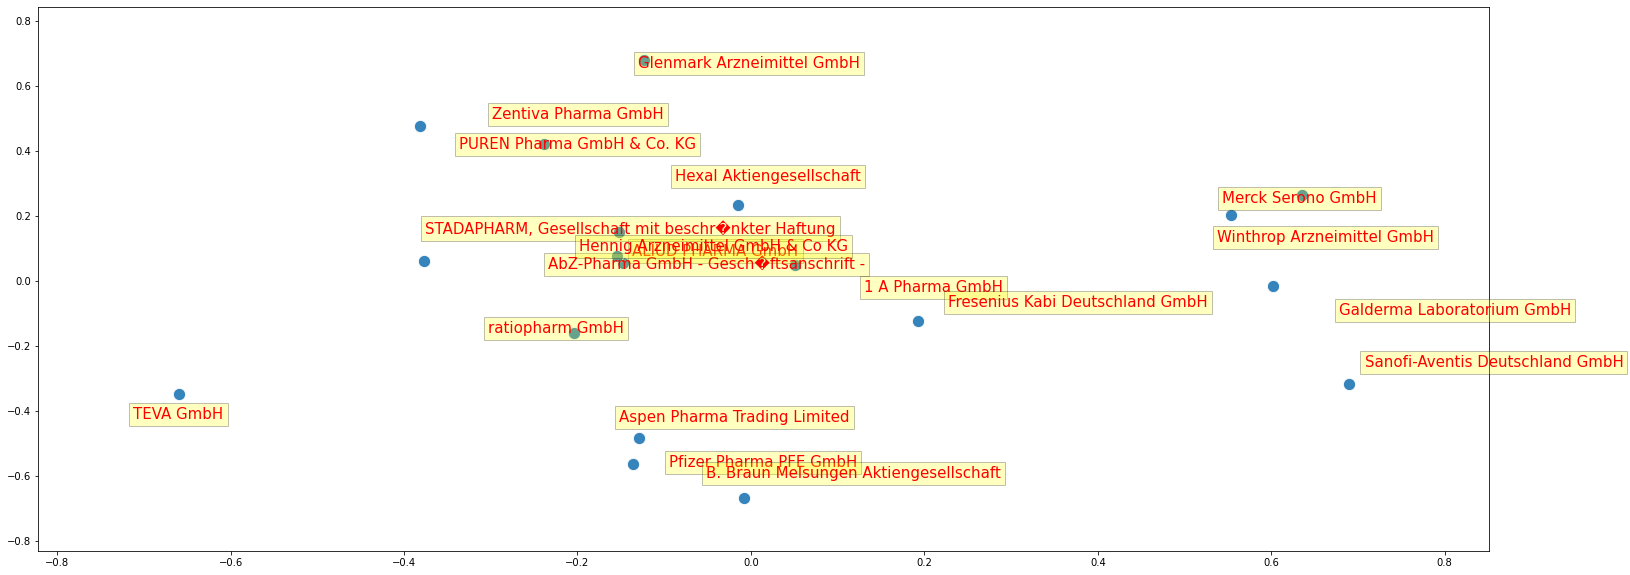

In [221]:
plt.figure(figsize=(26,10))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    #hue="code",
    palette=sns.color_palette("hls", 3),
    #data=pca_result[:,:2],
    #legend="full",
    s=150,
    alpha=0.9
)

random.seed(9)
for i in range(len(names_comp)):
    r1 = 0.2*(random.random()-0.5)
    r2 = 0.2*(random.random()-0.5)
    plt.text(x=pca_result[i, 0]+r1, y=pca_result[i,1] + r2, s=names_comp[i], 
          fontdict=dict(color='red',size=15),
          bbox=dict(facecolor='yellow',alpha=0.25))
plt.margins(0.12)

In [222]:
0.1*(random.random()-0.5)

-0.012118359770024968

In [232]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=10000)
tsne_results = tsne.fit_transform(X_comp)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.536060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.917511
[t-SNE] KL divergence after 2000 iterations: 0.252752
t-SNE done! Time elapsed: 0.2584803104400635 seconds


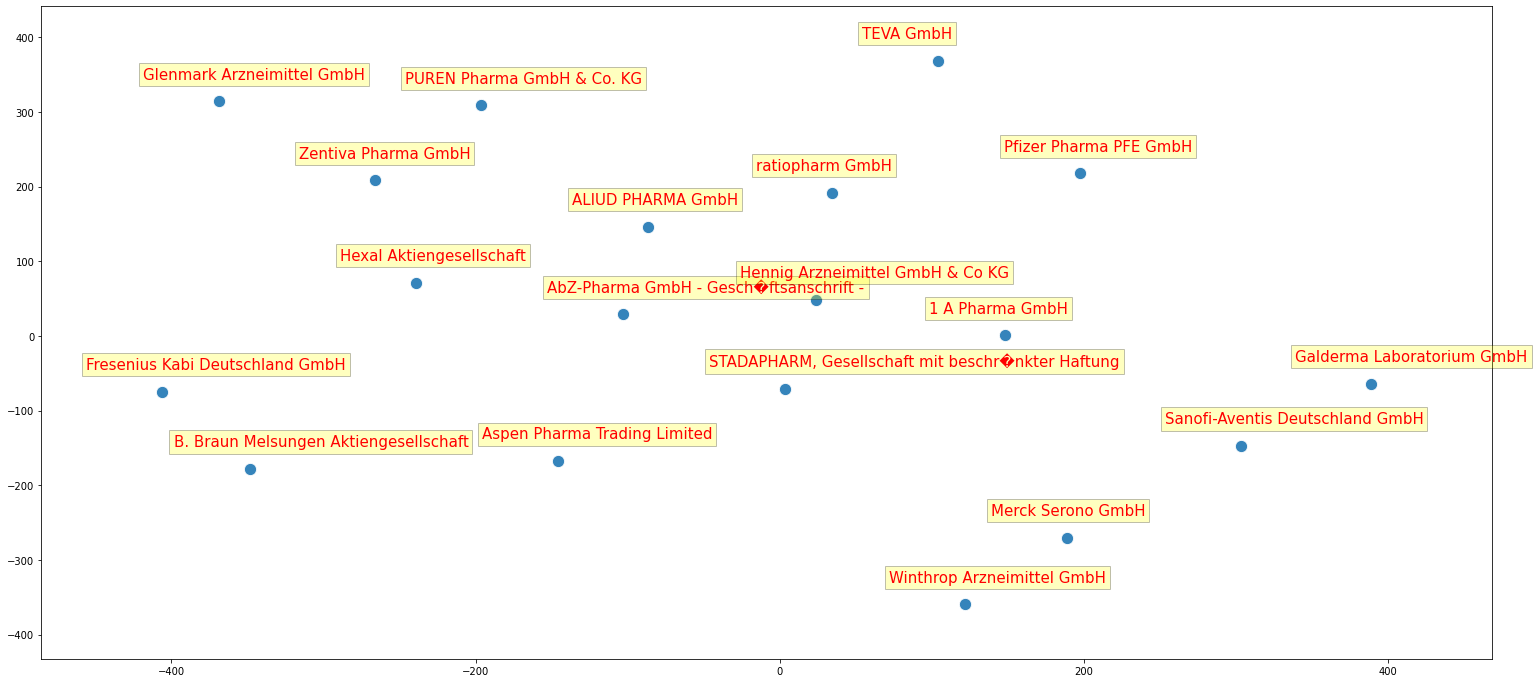

In [233]:
plt.figure(figsize=(26,12))
sns.scatterplot(
    x=tsne_results[:,0], 
    y=tsne_results[:,1],
    #hue="code",
    palette=sns.color_palette("hls", 3),
    #data=pca_result[:,:2],
    #legend="full",
    s=150,
    alpha=0.9
)

random.seed(9)
for i in range(len(names_comp)):
    r1 = -50 #0.2*(random.random()-0.5)
    r2 = 30 # 0.2*(random.random()-0.5)
    plt.text(x=tsne_results[i, 0]+r1, y=tsne_results[i,1] + r2, s=names_comp[i], 
          fontdict=dict(color='red',size=15),
          bbox=dict(facecolor='yellow',alpha=0.25))
plt.margins(0.1)
# plt.subplots_adjust(left=0, right=26, top=20, bottom=0)

In [227]:
names_comp

['Glenmark Arzneimittel GmbH',
 'Hexal Aktiengesellschaft',
 'ratiopharm GmbH',
 '1 A Pharma GmbH',
 'ALIUD PHARMA GmbH',
 'Merck Serono GmbH',
 'Pfizer Pharma PFE GmbH',
 'PUREN Pharma GmbH & Co. KG',
 'TEVA GmbH',
 'STADAPHARM, Gesellschaft mit beschr�nkter Haftung',
 'Sanofi-Aventis Deutschland GmbH',
 'Aspen Pharma Trading Limited',
 'AbZ-Pharma GmbH - Gesch�ftsanschrift -',
 'Fresenius Kabi Deutschland GmbH',
 'Winthrop Arzneimittel GmbH',
 'Hennig Arzneimittel GmbH & Co KG',
 'B. Braun Melsungen Aktiengesellschaft',
 'Zentiva Pharma GmbH',
 'Galderma Laboratorium GmbH']

In [228]:
def cosine(x, y):
    if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
        return 0
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [234]:
for i in range(len(names_comp)):
    for j in range(len(names_comp)):
        print(names_comp[i], names_comp[j], 
              cosine(node_embeddings[names_comp[i]], node_embeddings[names_comp[j]]))

Glenmark Arzneimittel GmbH Glenmark Arzneimittel GmbH 0.99999994
Glenmark Arzneimittel GmbH Hexal Aktiengesellschaft 0.4213748
Glenmark Arzneimittel GmbH ratiopharm GmbH -0.029960323
Glenmark Arzneimittel GmbH 1 A Pharma GmbH 0.015289158
Glenmark Arzneimittel GmbH ALIUD PHARMA GmbH 0.18123236
Glenmark Arzneimittel GmbH Merck Serono GmbH 0.07991806
Glenmark Arzneimittel GmbH Pfizer Pharma PFE GmbH -0.2392924
Glenmark Arzneimittel GmbH PUREN Pharma GmbH & Co. KG 0.6958099
Glenmark Arzneimittel GmbH TEVA GmbH 0.019192358
Glenmark Arzneimittel GmbH STADAPHARM, Gesellschaft mit beschr�nkter Haftung 0.16226988
Glenmark Arzneimittel GmbH Sanofi-Aventis Deutschland GmbH -0.43104357
Glenmark Arzneimittel GmbH Aspen Pharma Trading Limited -0.3225652
Glenmark Arzneimittel GmbH AbZ-Pharma GmbH - Gesch�ftsanschrift - 0.18049264
Glenmark Arzneimittel GmbH Fresenius Kabi Deutschland GmbH 0.111596145
Glenmark Arzneimittel GmbH Winthrop Arzneimittel GmbH 0.08207281
Glenmark Arzneimittel GmbH Hennig Arz